## Part 1 : Preprocessing <a class="anchor" id="chapter1"></a>

### Part 1.1 : Libraries & data loading <a class="anchor" id="section_1_1"></a>

Do this in order to install Reddit Python library:
`pip install praw`.

Library docs: https://praw.readthedocs.io/en/stable/getting_started/quick_start.html



Now we need to setup Reddit data fetching. For this we need to have a Reddit account.

We'll use posts from https://www.reddit.com/r/Paranormal/comments/gc4ive/i_made_another_big_list_of_paranormal_and_mystery/ for inspiration.

Now, create `client_id` and `client_secret`.

How?
  - Create a Reddit account if you don't have one yet
  - Go to https://www.reddit.com/prefs/apps and click `create an app`
  - Pick `script` app type. Name and description can be anything, but make sure to specify `http://localhost:8080` as `redirect uri`
  - Press `create app`. Your `client_id` is the string under **personal use script** and `client_secret` is the string next to **secret**

In [113]:
import praw
import pandas as pd

reddit = praw.Reddit(
    client_id = 'vS1U6YCHrHykdBrZhxseiA',
    client_secret = 'AL5gAJdYN86p9G73xG9zs_TAXedcUQ',
    user_agent = 'praw'
)

# This function returns a Pandas dataframe
# containing reddit post comments, given its id
def getComments(id):
    submission = reddit.submission(id)
    pandas_list = []
    commentsList = submission.comments.list()
    for i in range(min(50, len(commentsList))):
        pandas_list.append([i, commentsList[i].body])
    df = pd.DataFrame(pandas_list)
    df.columns = ['id', 'description']
    return df

In [114]:
# test getComments()
df = getComments('1n9pg5')

Install libraries & load data

1. Import pandas, numpy, spacy, sklearn (TfidfVectorizer, DBSCAN and TruncatedSVD), matplotlib and wordcloud.

   `en_core_web_sm` is a trained English pipeline.

In [115]:
import pandas as pd
import numpy as np

import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
import wordcloud

2. Read reddit comments and put it in a DataFrame named `corpus`.

In [116]:
corpus = getComments('1n9pg5')#pd.read_csv('./sample_data.csv')

In [117]:
print(corpus.shape)
corpus.head()

(50, 2)


,id,description
0,0,"Ancient Aliens, Imagine having to explain to t..."
1,1,I think the theory of technology being suppres...
2,2,The one world government thing. I think once e...
3,3,A coworker of mine has an interesting theory a...
4,4,Cows are aliens that traveled to Earth long ag...


In [118]:
print('Description of the first product : ',corpus.loc[0,'description'])

Description of the first product :  Ancient Aliens, Imagine having to explain to the world Tsoukalos was right all along..


### Part 1.2 : Text preprocessings <a class="anchor" id="section_1_2"></a>

3. Use `str` methods to clean the texts. Save cleaned-up text into a column named `clean_description`.

In [119]:
# Remove HTML elements
corpus['clean_description'] = corpus['description'].str.replace(r"<[a-z/]+>", " ") 
# Remove special characters and numbers
corpus['clean_description'] = corpus['clean_description'].str.replace(r"[^A-Za-z]+", " ") 
print('Description cleaned of the first product : ',corpus.loc[0,'clean_description'])

Description cleaned of the first product :  Ancient Aliens, Imagine having to explain to the world Tsoukalos was right all along..


4. Tranform every character into lowercase.

In [120]:
# Lowercase
corpus['clean_description'] = corpus['clean_description'].str.lower()
print('Description in lower case of the first product : ',corpus.loc[0,'clean_description'])

Description in lower case of the first product :  ancient aliens, imagine having to explain to the world tsoukalos was right all along..


5. Use spacy to tokenize the documents and put the result in a new column named `clean_tokens`.

In [121]:
## Tokenize the cleaned description
corpus['clean_tokens'] = corpus['clean_description'].apply(lambda x: nlp(x))
corpus.head()

,id,description,clean_description,clean_tokens
0,0,"Ancient Aliens, Imagine having to explain to t...","ancient aliens, imagine having to explain to t...","(ancient, aliens, ,, imagine, having, to, expl..."
1,1,I think the theory of technology being suppres...,i think the theory of technology being suppres...,"(i, think, the, theory, of, technology, being,..."
2,2,The one world government thing. I think once e...,the one world government thing. i think once e...,"(the, one, world, government, thing, ., i, thi..."
3,3,A coworker of mine has an interesting theory a...,a coworker of mine has an interesting theory a...,"(a, coworker, of, mine, has, an, interesting, ..."
4,4,Cows are aliens that traveled to Earth long ag...,cows are aliens that traveled to earth long ag...,"(cows, are, aliens, that, traveled, to, earth,..."


6. Remove the stop words and lemmatize `clean_tokens`

In [122]:
# Remove stop words
from spacy.lang.en.stop_words import STOP_WORDS

corpus['clean_tokens'] = corpus['clean_tokens'].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
corpus.head()

,id,description,clean_description,clean_tokens
0,0,"Ancient Aliens, Imagine having to explain to t...","ancient aliens, imagine having to explain to t...","[ancient, alien, ,, imagine, have, explain, wo..."
1,1,I think the theory of technology being suppres...,i think the theory of technology being suppres...,"[think, theory, technology, suppress, big, cor..."
2,2,The one world government thing. I think once e...,the one world government thing. i think once e...,"[world, government, thing, ., think, expose, ,..."
3,3,A coworker of mine has an interesting theory a...,a coworker of mine has an interesting theory a...,"[coworker, interesting, theory, humanity, ., \..."
4,4,Cows are aliens that traveled to Earth long ag...,cows are aliens that traveled to earth long ag...,"[cow, alien, travel, earth, long, ago, ., , t..."


7. Write all the cleaned tokens into one single string and put it in a new column named `clean_document`.

In [123]:
# Put back tokens into one single string
corpus["clean_document"] = [" ".join(x) for x in corpus['clean_tokens']]
corpus.head()

,id,description,clean_description,clean_tokens,clean_document
0,0,"Ancient Aliens, Imagine having to explain to t...","ancient aliens, imagine having to explain to t...","[ancient, alien, ,, imagine, have, explain, wo...","ancient alien , imagine have explain world tso..."
1,1,I think the theory of technology being suppres...,i think the theory of technology being suppres...,"[think, theory, technology, suppress, big, cor...",think theory technology suppress big corporati...
2,2,The one world government thing. I think once e...,the one world government thing. i think once e...,"[world, government, thing, ., think, expose, ,...","world government thing . think expose , power ..."
3,3,A coworker of mine has an interesting theory a...,a coworker of mine has an interesting theory a...,"[coworker, interesting, theory, humanity, ., \...",coworker interesting theory humanity . \n\n ba...
4,4,Cows are aliens that traveled to Earth long ag...,cows are aliens that traveled to earth long ag...,"[cow, alien, travel, earth, long, ago, ., , t...",cow alien travel earth long ago . teach man ...


### Part 1 conclusion :
Now we have the `clean_document` feature which is cleaned. We can train some NLP model on it.

## Part 2 - Clustering model --> Identify similar products <a class="anchor" id="chapter2"></a>

1. Perform TF-IDF transformation using the data from the column `clean_document`.

In [124]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus["clean_document"])

# X is a generator. We can transform that as an array
X = X.toarray()
print(X.shape)

(50, 516)


In [125]:
# Print the 50 first words into our vocabulary
print(sorted(vectorizer.vocabulary_.items())[:50])

[('000', 0), ('03', 1), ('100', 2), ('11', 3), ('2012', 4), ('2013', 5), ('250', 6), ('48', 7), ('50', 8), ('500', 9), ('51', 10), ('6241', 11), ('89', 12), ('accurate', 13), ('actually', 14), ('advanced', 15), ('african', 16), ('afterlife', 17), ('age', 18), ('ago', 19), ('agreement', 20), ('aid', 21), ('air', 22), ('aliean', 23), ('alien', 24), ('alive', 25), ('alliance', 26), ('alter', 27), ('american', 28), ('amish', 29), ('ancient', 30), ('animal', 31), ('annihilate', 32), ('answer', 33), ('area', 34), ('artificial', 35), ('assassination', 36), ('average', 37), ('away', 38), ('babyboomer', 39), ('balance', 40), ('basically', 41), ('beautiful', 42), ('belgium', 43), ('believe', 44), ('belong', 45), ('big', 46), ('biology', 47), ('black', 48), ('blow', 49)]


2. Create a DataFrame containing the result from TF-IDF

In [126]:
# Create a dataframe with tf-idf
X_df = pd.DataFrame(X, 
             columns=vectorizer.get_feature_names_out(), 
             index=["item_{}".format(x) for x in range(corpus.shape[0])] )

X_df.head()

,000,03,100,11,2012,2013,250,48,50,500,...,wow,write,wrong,www,xbox,yeah,year,young,zapatopi,zuko
item_0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
item_1,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
item_2,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
item_3,0.164665,0.0,0.074457,0.082333,0.0,0.0,0.082333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
item_4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.144003,0.0,0.0,0.0


- Each line of X correspond to a product description.
- Each column of X correspond to a word into the vocabulary.
- So each cell of X correspond to the score TF-IDF for a word in a product description.

3. Use DBSCAN to make some clustering on the TF-IDF matrix.

DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. It belongs to the unsupervised learning family of clustering algorithms.

When it comes to clustering, usually K-means or Hierarchical clustering algorithms are more popular. But they work well only when the clusters are simple to detect. They will not produce good results when the clusters have complex shapes or structures and this is where the DBSCAN algorithm gets the upper hand.

- When dealing with texts, the distance metric to be used is cosine instead of euclidean 
- eps = 0.7 and min samples = 3 enable to have almost 15 clusters without too much outliers

### TF-IDF vectorizer написаний вручну

In [127]:
from Auxiliary_file import tf_idf
# X = tf_idf(corpus['clean_document']) 

In [128]:
# Clustering on documents with DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=3, metric="cosine", algorithm="brute")

# Fit on data 
#No need to normalize data, it already is due to TF-IDF
clustering.fit(X)

# Write cluster ids into corpus and X_df
corpus['cluster_id'] = clustering.labels_
display(corpus.head())
X_df['cluster_id'] = clustering.labels_
display(X_df.head())

,id,description,clean_description,clean_tokens,clean_document,cluster_id
0,0,"Ancient Aliens, Imagine having to explain to t...","ancient aliens, imagine having to explain to t...","[ancient, alien, ,, imagine, have, explain, wo...","ancient alien , imagine have explain world tso...",-1
1,1,I think the theory of technology being suppres...,i think the theory of technology being suppres...,"[think, theory, technology, suppress, big, cor...",think theory technology suppress big corporati...,-1
2,2,The one world government thing. I think once e...,the one world government thing. i think once e...,"[world, government, thing, ., think, expose, ,...","world government thing . think expose , power ...",-1
3,3,A coworker of mine has an interesting theory a...,a coworker of mine has an interesting theory a...,"[coworker, interesting, theory, humanity, ., \...",coworker interesting theory humanity . \n\n ba...,-1
4,4,Cows are aliens that traveled to Earth long ag...,cows are aliens that traveled to earth long ag...,"[cow, alien, travel, earth, long, ago, ., , t...",cow alien travel earth long ago . teach man ...,-1


,000,03,100,11,2012,2013,250,48,50,500,...,write,wrong,www,xbox,yeah,year,young,zapatopi,zuko,cluster_id
item_0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,-1
item_1,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,-1
item_2,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,-1
item_3,0.164665,0.0,0.074457,0.082333,0.0,0.0,0.082333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,-1
item_4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.144003,0.0,0.0,0.0,-1


4. Display number of documents in each cluster

In [129]:
# Number of documents in each cluster
corpus['cluster_id'].value_counts()

cluster_id
-1    44
 0     3
 1     3
Name: count, dtype: int64

5. Print a sample of 3 documents that belong to 5 clusters

In [130]:
# Print sample of 3 documents for the 5 first cluster
for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c , ' :')
    print('----')
    for d in corpus.loc[corpus['cluster_id']==c,:].sample(3)['clean_description']:
        print(d)
        print()
    print('-----------')

CLUSTER  -1  :
----
there's a god and the amish way of life is the only way to get to heaven. 

zuko's mom was an earthbender.


how about no.

the theory where the middle ages are a myth... we missed like 500 years of (relatively) recent history

-----------
CLUSTER  0  :
----
[deleted]

[deleted]

[deleted]

-----------
CLUSTER  1  :
----
l is real.

our universe is just one of many simulations in a computer.

you are the only real person. everyone else is just part of the computer simulation.

-----------


6. Print the 5 most frequent words in the 5 first clusters

In [131]:
# 5 Most frequent words in each cluster
cols = [c for c in X_df.columns if c!='cluster_id']

for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c)
    print(X_df.loc[X_df['cluster_id']==c,cols].mean(axis=0).sort_values(ascending=False)[0:5])
    print('-----------')

CLUSTER  -1
world     0.043664
earth     0.040643
alien     0.040515
people    0.034266
know      0.033561
dtype: float64
-----------
CLUSTER  0
delete    1.0
000       0.0
real      0.0
race      0.0
quo       0.0
dtype: float64
-----------
CLUSTER  1
real          0.485461
simulation    0.365505
computer      0.338074
universe      0.210084
person        0.175517
dtype: float64
-----------


7. Wordcloud for the 5 first clusters

CLUSTER  -1


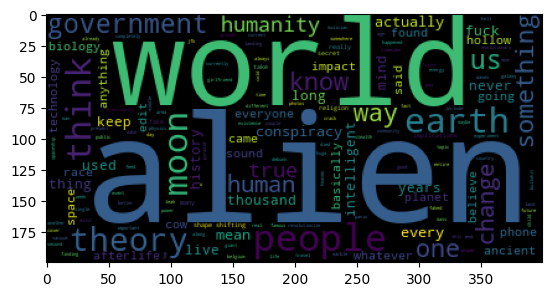

-----------
CLUSTER  0


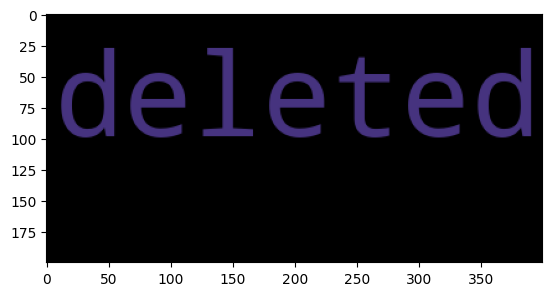

-----------
CLUSTER  1


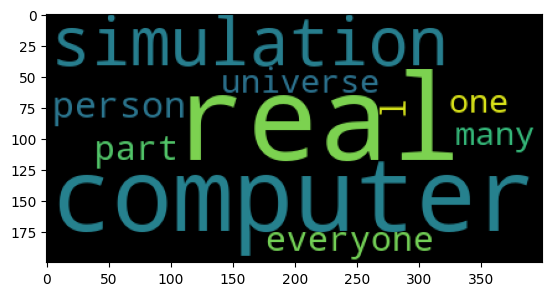

-----------


In [132]:
# Word cloud for the 5 first clusters
wd = wordcloud.WordCloud()
for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c)
    texts = " ".join(corpus.loc[corpus['cluster_id']==c,'clean_description'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    print('-----------')

## Part 3 - Recommender system <a class="anchor" id="chapter3"></a>

Now, we use the clusters created from part 1 to build a recommender system. 
The aim is to be able to suggest to a user some products that are similar to the ones he is interested in. To do this, we consider that products belonging to the same cluster are similar.

In [133]:
corpus.head()

,id,description,clean_description,clean_tokens,clean_document,cluster_id
0,0,"Ancient Aliens, Imagine having to explain to t...","ancient aliens, imagine having to explain to t...","[ancient, alien, ,, imagine, have, explain, wo...","ancient alien , imagine have explain world tso...",-1
1,1,I think the theory of technology being suppres...,i think the theory of technology being suppres...,"[think, theory, technology, suppress, big, cor...",think theory technology suppress big corporati...,-1
2,2,The one world government thing. I think once e...,the one world government thing. i think once e...,"[world, government, thing, ., think, expose, ,...","world government thing . think expose , power ...",-1
3,3,A coworker of mine has an interesting theory a...,a coworker of mine has an interesting theory a...,"[coworker, interesting, theory, humanity, ., \...",coworker interesting theory humanity . \n\n ba...,-1
4,4,Cows are aliens that traveled to Earth long ag...,cows are aliens that traveled to earth long ag...,"[cow, alien, travel, earth, long, ago, ., , t...",cow alien travel earth long ago . teach man ...,-1


1. Create a function named `find_similar_items` that will return the 5 item ids belonging to the same cluster as the product `item_id`.

In [134]:
def find_similar_items(item_id):
    """
    Return 5 product ids belonging to the same cluster as item_id
    """
    cluster_id = corpus.loc[corpus['id']==item_id, 'cluster_id'].values[0]
    similar_items = corpus.loc[corpus['cluster_id']==cluster_id,:].sample(5)
    similar_item_ids = similar_items['id'].unique()
    return similar_item_ids

2. Use `input()` function to allow the user to choose a product and submit some suggestions of similar items.

In [135]:
# For printing in colors
class bcolors:
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'

In [136]:
product_id = int(input("What product would you like to buy ? "))
print()
try:
    item_desc = corpus.loc[corpus['id']==product_id, 'clean_description'].values[0]
except:
    print('Product not found in database. Please enter a valid product id.')
else:
    print(f"{bcolors.OKBLUE}Product found in database, description below :")
    print(item_desc)
    print()
    
    print("Based on the analysis of the products' descriptions, you might also be interested by the following products : ")
    print()

    for i in find_similar_items(product_id):
        print(f"{bcolors.OKGREEN}Item #", i)
        print(corpus.loc[corpus['id']==i, 'clean_description'].values[0])
        print('--------------------')


Product found in database, description below :
it's kind of a personal theory but sometimes during the day i get phone calls on my landline where i answer the phone but nobody's there at the other end, then after 2 or 3 seconds the line goes dead. i get these on average 3 times a week. i have a theory that these are burglars seeing if i'm home. if this was true i'd freak the fuck out. 

Based on the analysis of the products' descriptions, you might also be interested by the following products : 

Item # 37
zuko's mom was an earthbender.


how about no.
--------------------
Item # 18
aids and crack was in fact manufactured by the us government to try to destabilize the african american community. 
--------------------
Item # 36
that whatever was in the safe was so unspeakably important to humanity that it needed to be covered up because it might upset the delicate world balance.
--------------------
Item # 1
i think the theory of technology being suppressed by big corporations could ha

## Part 4 - LSA for topic extraction <a class="anchor" id="chapter4"></a>

- Latent Semantic Analysis, or LSA, is one of the foundational techniques in topic modeling. The core idea is to take a matrix of what we have — documents and terms — and decompose it into a separate document-topic matrix and a topic-term matrix.

- The main goal of this part is to find relevant topics for each documents. Contrary to clustering, a unique documents can have multiple topics. For example Sport and Politics.

1. Use TruncatedSVD to make some topic extraction from the TF-IDF matrix.

In [137]:
# Train SVD model
svd_model = TruncatedSVD(n_components=12) # We test on 12 topics
lsa = svd_model.fit_transform(X)
topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_" + str(i) for i in range(lsa.shape[1])])
topic_encoded_df["documents"] = corpus['clean_description']
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents
0,-0.000116,0.227762,-0.079060,-0.114299,-0.153487,-0.145145,-0.151857,-0.064591,-0.076440,0.378016,-0.089379,-0.201143,"ancient aliens, imagine having to explain to t..."
1,-0.000643,0.208695,-0.018588,0.075571,-0.239429,0.377556,-0.123519,0.090514,0.086769,-0.091973,0.025313,-0.074614,i think the theory of technology being suppres...
2,-0.000065,0.272361,-0.103416,0.085654,-0.265099,-0.222224,0.084464,-0.239279,-0.037084,-0.313992,-0.062125,0.047261,the one world government thing. i think once e...
3,0.000340,0.465314,-0.148029,-0.022934,0.232653,-0.019832,-0.117284,-0.085108,0.014683,-0.002036,-0.013198,0.003611,a coworker of mine has an interesting theory a...
4,0.000161,0.173646,-0.047145,0.079968,0.072771,-0.062838,-0.097668,0.031700,-0.032744,0.063308,0.166736,-0.220946,cows are aliens that traveled to earth long ag...


Contrary to clustering, LSA allows to map each document to a mix of several topics. For this reason, it's a bit more difficult to interpret the topics as categories : one document can actually be related to several topics at a time. To make things easier, we can extract the main topic of each document.

2. Create a new column named `main_topic` in `topic_encoded_df` where we store the main topics related to each document.

In [138]:
def extract_main_topics(x):
    """
    Return the main topic for each document. The main topic is that have the maximum value for each line
    """
    topics = np.abs(x)
    main_topic = topics.sort_values(ascending=False).index[0]
    return main_topic

# Initialize column main_topics with 0
topic_encoded_df.loc[:, 'main_topic'] = 0

for i, row in topic_encoded_df.iloc[:,:-2].iterrows():
    topic_encoded_df.loc[i, 'main_topic'] = extract_main_topics(row)

topic_encoded_df.head()

C:\Users\Alex\AppData\Local\Temp\ipykernel_716\3040406549.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'topic_9' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  topic_encoded_df.loc[i, 'main_topic'] = extract_main_topics(row)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,-0.000116,0.227762,-0.079060,-0.114299,-0.153487,-0.145145,-0.151857,-0.064591,-0.076440,0.378016,-0.089379,-0.201143,"ancient aliens, imagine having to explain to t...",topic_9
1,-0.000643,0.208695,-0.018588,0.075571,-0.239429,0.377556,-0.123519,0.090514,0.086769,-0.091973,0.025313,-0.074614,i think the theory of technology being suppres...,topic_5
2,-0.000065,0.272361,-0.103416,0.085654,-0.265099,-0.222224,0.084464,-0.239279,-0.037084,-0.313992,-0.062125,0.047261,the one world government thing. i think once e...,topic_9
3,0.000340,0.465314,-0.148029,-0.022934,0.232653,-0.019832,-0.117284,-0.085108,0.014683,-0.002036,-0.013198,0.003611,a coworker of mine has an interesting theory a...,topic_1
4,0.000161,0.173646,-0.047145,0.079968,0.072771,-0.062838,-0.097668,0.031700,-0.032744,0.063308,0.166736,-0.220946,cows are aliens that traveled to earth long ag...,topic_11


3. Count each main topic in the corpus 

In [139]:
topic_encoded_df['main_topic'].value_counts()

main_topic
topic_1     7
topic_11    7
topic_9     6
topic_8     5
topic_3     4
topic_2     4
topic_6     3
topic_7     3
topic_4     3
topic_0     3
topic_10    3
topic_5     2
Name: count, dtype: int64

- topic_0 is the most represented topic, as it's the main topic for more than `50%` of the documents of the corpus.

4. Use the attribute `components_` of the SVD model to print the 5 most important words in each topic.

In [140]:
# Create DataFrame containing the description of each topic in terms of the words in the vocabulary
topics_description = pd.DataFrame(svd_model.components_, columns = vectorizer.get_feature_names_out(), 
                                  index = ['topic_' + str(i) for i in range(svd_model.components_.shape[0])])

# Compute absolute values of coefficients
topics_description = topics_description.apply(np.abs, axis = 1)

# Each word is map with a score of relevance for each topic
topics_description.head()

,000,03,100,11,2012,2013,250,48,50,500,...,wow,write,wrong,www,xbox,yeah,year,young,zapatopi,zuko
topic_0,0.000053,0.000027,0.000118,0.000027,0.000732,0.000027,0.000027,0.000046,0.000046,0.000028,...,0.000103,0.000118,0.000008,0.000094,0.000177,0.000046,0.000038,0.000037,0.000421,0.000016
topic_1,0.037362,0.007665,0.045441,0.018681,0.049319,0.007665,0.018681,0.013528,0.013528,0.028722,...,0.049953,0.023874,0.040269,0.026953,0.022658,0.013528,0.059853,0.031154,0.007204,0.008627
topic_2,0.013199,0.000677,0.018007,0.006600,0.023540,0.000677,0.006600,0.006298,0.006298,0.013671,...,0.024295,0.005980,0.012739,0.055453,0.013970,0.006298,0.025605,0.011646,0.009411,0.004791
topic_3,0.003758,0.002889,0.002986,0.001879,0.241438,0.002889,0.001879,0.002089,0.002089,0.043713,...,0.096930,0.002977,0.033506,0.002579,0.044884,0.002089,0.016221,0.004823,0.009886,0.007526
topic_4,0.026336,0.018700,0.028207,0.013168,0.093586,0.018700,0.013168,0.008424,0.008424,0.029792,...,0.158980,0.013369,0.019478,0.033431,0.039533,0.008424,0.003252,0.015553,0.014466,0.024451


In [141]:
# Loop over each topic and print the 5 most important words
for i,row in topics_description.iterrows():
    print('TOPIC :', i)
    print(row.sort_values(ascending=False)[0:5].index.tolist())
    print()
    print('-------------------------')
    print()

TOPIC : topic_0
['delete', '6241', 'belgium', '2012', 'end']

-------------------------

TOPIC : topic_1
['world', 'alien', 'real', 'people', 'know']

-------------------------

TOPIC : topic_2
['real', 'simulation', 'computer', 'person', 'universe']

-------------------------

TOPIC : topic_3
['earth', 'people', 'end', 'know', '2012']

-------------------------

TOPIC : topic_4
['know', 'world', 'black', 'people', 'way']

-------------------------

TOPIC : topic_5
['phone', 'world', 'way', 'theory', 'technology']

-------------------------

TOPIC : topic_6
['phone', 'real', 'computer', 'guess', 'simulation']

-------------------------

TOPIC : topic_7
['mom', 'people', 'government', 'earthbender', 'zuko']

-------------------------

TOPIC : topic_8
['phone', 'way', 'guess', 'life', 'real']

-------------------------

TOPIC : topic_9
['government', 'actually', 'matrix', 'world', 'alien']

-------------------------

TOPIC : topic_10
['like', 'real', 'simulation', 'middle', 'year']

----

5. Make a wordcloud describing each topic and compare to the ones we obtain with clustering

In [142]:
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,-0.000116,0.227762,-0.079060,-0.114299,-0.153487,-0.145145,-0.151857,-0.064591,-0.076440,0.378016,-0.089379,-0.201143,"ancient aliens, imagine having to explain to t...",topic_9
1,-0.000643,0.208695,-0.018588,0.075571,-0.239429,0.377556,-0.123519,0.090514,0.086769,-0.091973,0.025313,-0.074614,i think the theory of technology being suppres...,topic_5
2,-0.000065,0.272361,-0.103416,0.085654,-0.265099,-0.222224,0.084464,-0.239279,-0.037084,-0.313992,-0.062125,0.047261,the one world government thing. i think once e...,topic_9
3,0.000340,0.465314,-0.148029,-0.022934,0.232653,-0.019832,-0.117284,-0.085108,0.014683,-0.002036,-0.013198,0.003611,a coworker of mine has an interesting theory a...,topic_1
4,0.000161,0.173646,-0.047145,0.079968,0.072771,-0.062838,-0.097668,0.031700,-0.032744,0.063308,0.166736,-0.220946,cows are aliens that traveled to earth long ag...,topic_11


-------------------------

TOPIC  topic_0


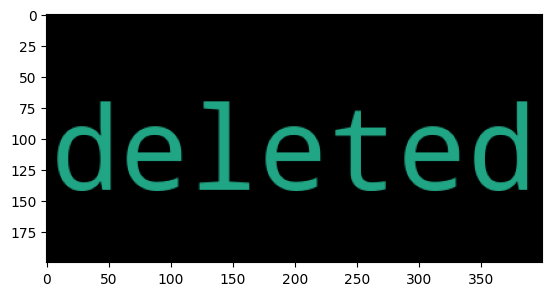


-------------------------

TOPIC  topic_1


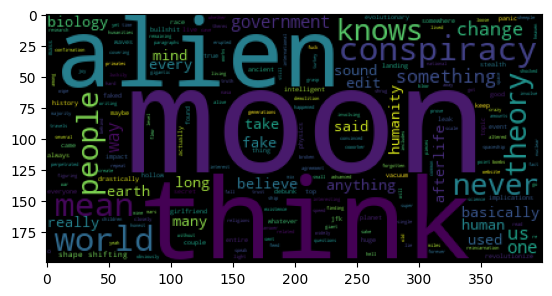


-------------------------

TOPIC  topic_2


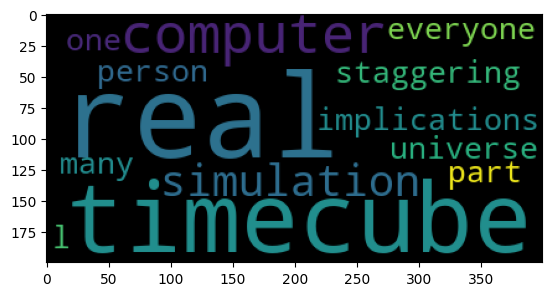


-------------------------

TOPIC  topic_3


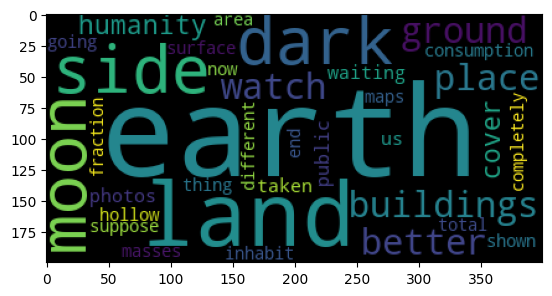


-------------------------

TOPIC  topic_4


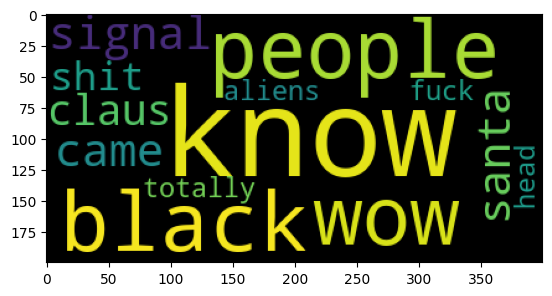


-------------------------

TOPIC  topic_5


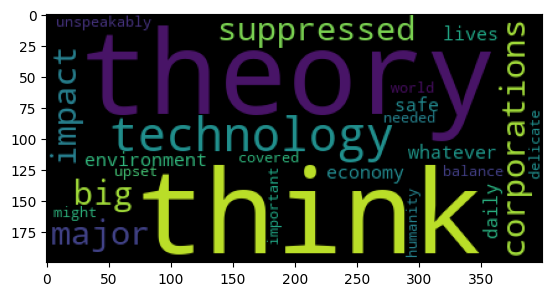


-------------------------

TOPIC  topic_6


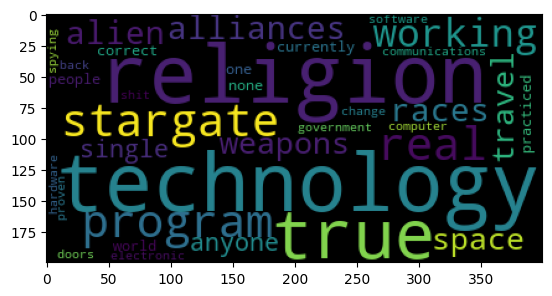


-------------------------

TOPIC  topic_7


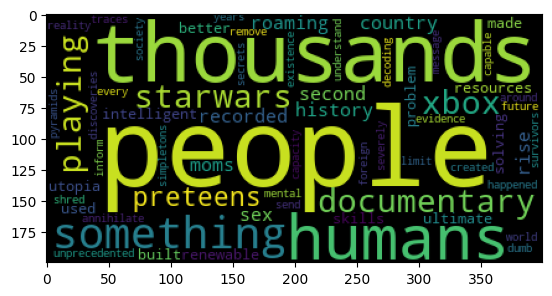


-------------------------

TOPIC  topic_8


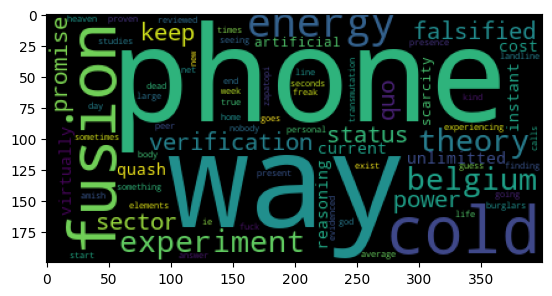


-------------------------

TOPIC  topic_9


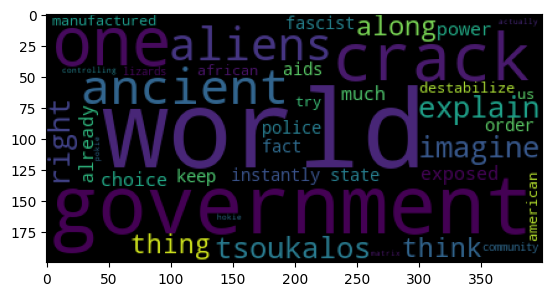


-------------------------

TOPIC  topic_10


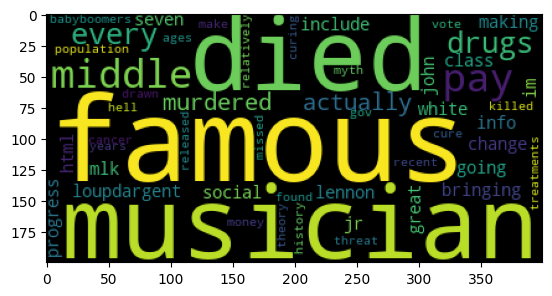


-------------------------

TOPIC  topic_11


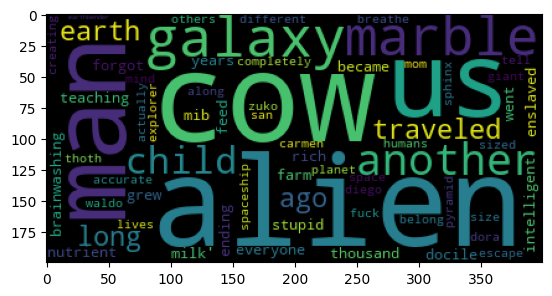

In [143]:
# Loop over each topic and create wordcloud from documents that are related to this main topic
wd = wordcloud.WordCloud()

cols = [c for c in topic_encoded_df.columns if 'topic_' in c]

for t in cols:
    print('-------------------------')
    print()
    print('TOPIC ', t)
    
    # Handle topics that are not main topics for any document in the corpus
    if (topic_encoded_df['main_topic']==t).any() == False :
        print('cannot create wordcloud for this topic')
        continue
    
    texts = " ".join(topic_encoded_df.loc[topic_encoded_df['main_topic']==t,'documents'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    
    print()

## Conclusion

- It's difficult to compare the results from the clustering and LSA, in particular because we didn't get exactly the same number of "topics" for both algorithms. However, the wordclouds are not fundamentally different (for example, both algorithms identify a group of documents or topic related to sun protection, organic cotton or merino wood).

- The major difference between these two approaches is that clustering maps a given document to a single group, whereas LSA links a document to several topics. For this reason, text clustering is usually more suitable for applications related to similarity measurements (for example, building a recommender system),  whereas LSA is widely used for topic modelling.